In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.stats
import json
import numpy as np

TOPIC_GRAPH = "../logs/topic_edges.tsv"
USER_GRAPH = "../logs/user_edges.tsv"
TOPIC_NODES = "../logs/topic_nodes.tsv"
USER_NODES = "../logs/user_nodes.tsv"
GILDS = "../logs/comment_gilds.json"
RANK = "../logs/comment_rank_all.json"
INPUT = "/dfs/dataset/infolab/Reddit/comments/2015/RC_2015-05"
POST_IDs = "../data/post_IDs.txt"
TOP_100 = "../logs/top_100subreddits_comments.txt"

/dfs/scratch1/lucy3/conda/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


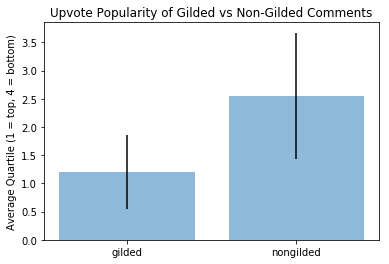

In [9]:
# for gilded versus nongilded, average and std for rank
def gild_and_rank():
    gilded_vals = []
    nongilded_vals = []
    with open(GILDS, 'r') as gilds_file:
        gilds = json.load(gilds_file)
    with open(RANK, 'r') as rank_file:
        rank = json.load(rank_file)
    for key in gilds:
        if gilds[key] >= 1:
            gilded_vals.append(rank[key])
        else:
            nongilded_vals.append(rank[key])
    print "gilded mean, std:", np.mean(gilded_vals), np.std(gilded_vals)
    print "nongilded mean, std:", np.mean(nongilded_vals), np.std(nongilded_vals)
    #gilded mean, std: 1.20753628761 0.65439670175
    #nongilded mean, std: 2.55127257704 1.12074075832
def bar_chart():
    plt.bar([1, 2], [1.20753628761, 2.55127257704], \
           yerr = [0.65439670175, 1.12074075832], align='center', alpha=0.5)
    plt.xticks([1, 2], ['gilded', 'nongilded'])
    plt.ylabel('Average Quartile (1 = top, 4 = bottom)')
    plt.title('Upvote Popularity of Gilded vs Non-Gilded Comments')
bar_chart()

In [7]:
# pearson correlation between topic similarity and user similarity graphs
def similarity():
    tnode_ids = {}
    with open(TOPIC_NODES, 'r') as tnodes_file:
        for line in tnodes_file:
            contents = line.split('\t')
            if contents[0] != 'Id':
                tnode_ids[contents[1]] = contents[0]
    unode_ids = {}
    with open(USER_NODES, 'r') as unodes_file:
        for line in unodes_file:
            contents = line.split('\t')
            if contents[0] != 'Id':
                unode_ids[contents[1]] = contents[0]
    topic_sim = {}
    with open(TOPIC_GRAPH, 'r') as topic_file:
        for line in topic_file:
            contents = line.split('\t')
            if contents[0] != 'Source':
                topic_sim[tuple(sorted([contents[0], contents[1]]))] = float(contents[2])
    user_sim = {}
    with open(USER_GRAPH, 'r') as user_file:
        for line in user_file:
            contents = line.split('\t')
            if contents[0] != 'Source':
                user_sim[tuple(sorted([contents[0], contents[1]]))] = float(contents[2])
    x = []
    y = []
    for pair in itertools.combinations(tnode_ids.keys(), 2):
        pair_IDs = tuple(sorted([tnode_ids[pair[0]], tnode_ids[pair[1]]]))
        x.append(topic_sim[pair_IDs])
        pair_IDs = tuple(sorted([unode_ids[pair[0]], unode_ids[pair[1]]]))
        y.append(user_sim[pair_IDs])
    plt.scatter(x, y)
    print "Pearson correlation:", scipy.stats.pearsonr(x, y)
    plt.xlabel("topic similarity")
    plt.ylabel("user similarity")
    plt.title("Correlation of Subreddit Similarities")
    plt.show()

In [8]:
def count_deleted_gilds():
    subreddits = set()
    with open(TOP_100, 'r') as top: 
        for line in top: 
            subreddits.add(line.strip())
    with open(POST_IDs, 'r') as post_id_file: 
        # all posts in May 2015
        post_ids = set(post_id_file.read().split())
    scores = {}
    gilds = {}
    count = 0
    with open(INPUT, 'r') as input_file:
        for line in input_file:
            comment = json.loads(line)
            post_id = comment['link_id'].split('_')[-1]
            subreddit = comment['subreddit']
            if post_id in post_ids and subreddit in subreddits: 
                # only get comments of May 2015 posts
                # in the top 100 subreddits
                if comment['gilded'] == 1 and comment['author'] == "[deleted]":
                    count += 1
    print count